In [1]:
import pandas as pd

df = pd.read_csv('bank-additional-full.csv', delimiter=';')

In [2]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [4]:
df.shape

(41188, 21)

In [5]:
df.drop_duplicates(inplace=True)
df.shape

(41176, 21)

In [6]:
# no null values found!
# pd.isnull(df).sum()

In [7]:
# outlier detection & treatment with z-score method
from scipy.stats import zscore
import numpy as np

# Selecting numeric columns
df_numeric = df[['duration', 'campaign', 'pdays']]

# Computing absolute z-scores (force conversion to array)
z_scores = np.abs(zscore(df_numeric.to_numpy()))

# Capping outliers using 95th percentile
for i, col in enumerate(df_numeric.columns):
    upper_limit = df[col].quantile(0.95)
    df[col] = np.where(z_scores[:, i] > 3, upper_limit, df[col])

In [8]:
# List of numeric columns for outlier treatment
numeric_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 
                'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
                'euribor3m', 'nr.employed']

# Z-score threshold
threshold = 3

# Report before capping
print("Outlier counts BEFORE capping:")
before_counts = {}
for col in numeric_cols:
    z_scores = zscore(df[col])
    before_counts[col] = (np.abs(z_scores) > threshold).sum()
    print(f"{col}: {before_counts[col]} outliers")

# Apply Z-score capping
for col in numeric_cols:
    z_scores = zscore(df[col])
    abs_z_scores = np.abs(z_scores)
    
    # Get upper and lower caps
    upper_cap = df.loc[abs_z_scores < threshold, col].max()
    lower_cap = df.loc[abs_z_scores < threshold, col].min()
    
    # Cap values
    df[col] = np.where(df[col] > upper_cap, upper_cap,
                       np.where(df[col] < lower_cap, lower_cap, df[col]))


# Report after capping
print("\nOutlier counts AFTER capping:")
after_counts = {}
for col in numeric_cols:
    z_scores = zscore(df[col])
    after_counts[col] = (np.abs(z_scores) > threshold).sum()
    print(f"{col}: {after_counts[col]} outliers")

Outlier counts BEFORE capping:
age: 369 outliers
duration: 605 outliers
campaign: 908 outliers
pdays: 0 outliers
previous: 1064 outliers
emp.var.rate: 0 outliers
cons.price.idx: 0 outliers
cons.conf.idx: 0 outliers
euribor3m: 0 outliers
nr.employed: 0 outliers

Outlier counts AFTER capping:
age: 421 outliers
duration: 670 outliers
campaign: 0 outliers
pdays: 0 outliers
previous: 0 outliers
emp.var.rate: 0 outliers
cons.price.idx: 0 outliers
cons.conf.idx: 0 outliers
euribor3m: 0 outliers
nr.employed: 0 outliers


Outlier capping done for numeric columns and only the 'Duration' column had outliers.

In [9]:
# age IQR

Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
df['age'] = np.where(df['age'] > upper_bound, upper_bound, df['age'])

In [10]:
# Feature transformation using Encoding
from sklearn.preprocessing import LabelEncoder

# Label Encoding (for binary categorical columns)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in ['default', 'housing', 'loan', 'y']:
    df[col] = le.fit_transform(df[col])

In [11]:
# One hot encoding for multi-category columns

df = pd.get_dummies(df, columns=['job', 'education', 'poutcome'], drop_first=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41176 non-null  float64
 1   marital                        41176 non-null  object 
 2   default                        41176 non-null  int64  
 3   housing                        41176 non-null  int64  
 4   loan                           41176 non-null  int64  
 5   contact                        41176 non-null  object 
 6   month                          41176 non-null  object 
 7   day_of_week                    41176 non-null  object 
 8   duration                       41176 non-null  float64
 9   campaign                       41176 non-null  float64
 10  pdays                          41176 non-null  float64
 11  previous                       41176 non-null  int64  
 12  emp.var.rate                   41176 non-null  floa

In [13]:
# model-ready encoding + scaling pipeline

from sklearn.preprocessing import LabelEncoder, StandardScaler

# Making a copy to avoid changing original
df_model = df.copy()

# One-hot encode the remaining categorical columns with few categories
categorical_onehot = ['marital', 'contact', 'month', 'day_of_week']
df_model = pd.get_dummies(df_model, columns=categorical_onehot, drop_first=True)

# Label encoding the target column (y)
if df_model['y'].dtype == 'object':
    le = LabelEncoder()
    df_model['y'] = le.fit_transform(df_model['y'])

# Identifying numerical columns for scaling
numerical_cols = [
    'age', 'duration', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
    'euribor3m', 'nr.employed'
]

# Standard scaling
scaler = StandardScaler()
df_model[numerical_cols] = scaler.fit_transform(df_model[numerical_cols])

In [14]:
# training the df_model 
print(df_model.head())

        age  default  housing  loan  duration  campaign  pdays  previous  \
0  1.585672        0        0     0  0.086230 -0.784028    0.0 -0.397773   
1  1.684402        1        0     0 -0.474471 -0.784028    0.0 -0.397773   
2 -0.290190        0        2     0 -0.088989 -0.784028    0.0 -0.397773   
3  0.005999        0        0     0 -0.464459 -0.784028    0.0 -0.397773   
4  1.585672        0        0     2  0.316518 -0.784028    0.0 -0.397773   

   emp.var.rate  cons.price.idx  ...  month_jun  month_mar  month_may  \
0      0.648101        0.722628  ...      False      False       True   
1      0.648101        0.722628  ...      False      False       True   
2      0.648101        0.722628  ...      False      False       True   
3      0.648101        0.722628  ...      False      False       True   
4      0.648101        0.722628  ...      False      False       True   

   month_nov  month_oct  month_sep  day_of_week_mon  day_of_week_thu  \
0      False      False      Fal

The necessary steps for cleaning the data have been performed.

# Model Selection

### Logistic Regression

In [15]:
# loading libraries

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [16]:
# split features and target
X = df_model.drop('y', axis=1)
y = df_model['y']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# cross-validation accuracy
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')

# train on full training data
log_reg.fit(X_train, y_train)

# predictions
y_pred = log_reg.predict(X_test)

In [17]:
# metrics
print(f"Training Accuracy: {log_reg.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Cross-validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training Accuracy: 0.8576
Test Accuracy: 0.8616
Cross-validation Scores: [0.85761991 0.85686096 0.85458409 0.85777171 0.85913783]
Mean CV Accuracy: 0.8572

Confusion Matrix:
[[6252 1056]
 [  84  844]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7308
           1       0.44      0.91      0.60       928

    accuracy                           0.86      8236
   macro avg       0.72      0.88      0.76      8236
weighted avg       0.93      0.86      0.88      8236



### Decision Tree Classifier

In [18]:
# plain DecisionTreeClassifier

# from sklearn.tree import DecisionTreeClassifier

# # training the Decision Tree model
# dt_model = DecisionTreeClassifier(random_state=42)  
# dt_model.fit(X_train, y_train)

# # Predictions
# y_pred_dt = dt_model.predict(X_test)

# # Evaluation
# print("Accuracy:", accuracy_score(y_test, y_pred_dt))
# print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
# print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']  
}

# Model
dt = DecisionTreeClassifier(random_state=42)

# Grid search
grid_search = GridSearchCV(estimator=dt,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_dt = grid_search.best_estimator_

# Predictions
y_pred_best = best_dt.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy: 0.9123360854783875

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      7308
           1       0.62      0.56      0.59       928

    accuracy                           0.91      8236
   macro avg       0.78      0.76      0.77      8236
weighted avg       0.91      0.91      0.91      8236


Confusion Matrix:
 [[6990  318]
 [ 404  524]]


In [20]:
# Feature importance
import pandas as pd
feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feat_importance)

                          Feature  Importance
4                        duration    0.508516
12                    nr.employed    0.349553
32               poutcome_success    0.043254
11                      euribor3m    0.035085
10                  cons.conf.idx    0.033143
44                      month_oct    0.012255
9                  cons.price.idx    0.007934
36              contact_telephone    0.004231
42                      month_may    0.004226
46                day_of_week_mon    0.001013
23                    job_unknown    0.000790
37                      month_aug    0.000000
31           poutcome_nonexistent    0.000000
30              education_unknown    0.000000
33                marital_married    0.000000
34                 marital_single    0.000000
35                marital_unknown    0.000000
0                             age    0.000000
41                      month_mar    0.000000
38                      month_dec    0.000000
39                      month_jul 

### Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [22]:
print(f"Random Forest R² Score: {r2:.4f}")
print(f"Random Forest RMSE: {rmse:.4f}")

Random Forest R² Score: 0.4151
Random Forest RMSE: 0.2466


In [23]:
# Feature importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Important Features:")
print(importances.head(10))


Top 10 Important Features:
             Feature  Importance
4           duration    0.326841
12       nr.employed    0.157336
0                age    0.089557
11         euribor3m    0.082881
5           campaign    0.035177
10     cons.conf.idx    0.024657
32  poutcome_success    0.020333
2            housing    0.015659
9     cons.price.idx    0.013559
3               loan    0.012479


### XGBoost

In [24]:
from xgboost import XGBRegressor

# Initialize model
xgb_model = XGBRegressor(
    n_estimators=200,        # number of trees
    learning_rate=0.1,      # step size shrinkage
    max_depth=6,            # depth of each tree
    subsample=0.8,          # for regularization
    colsample_bytree=0.8,   # fraction of features per tree
    random_state=42
)

# Fit model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

In [25]:
print(f"R² Score: {r2_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")

R² Score: 0.4233
RMSE: 0.2449


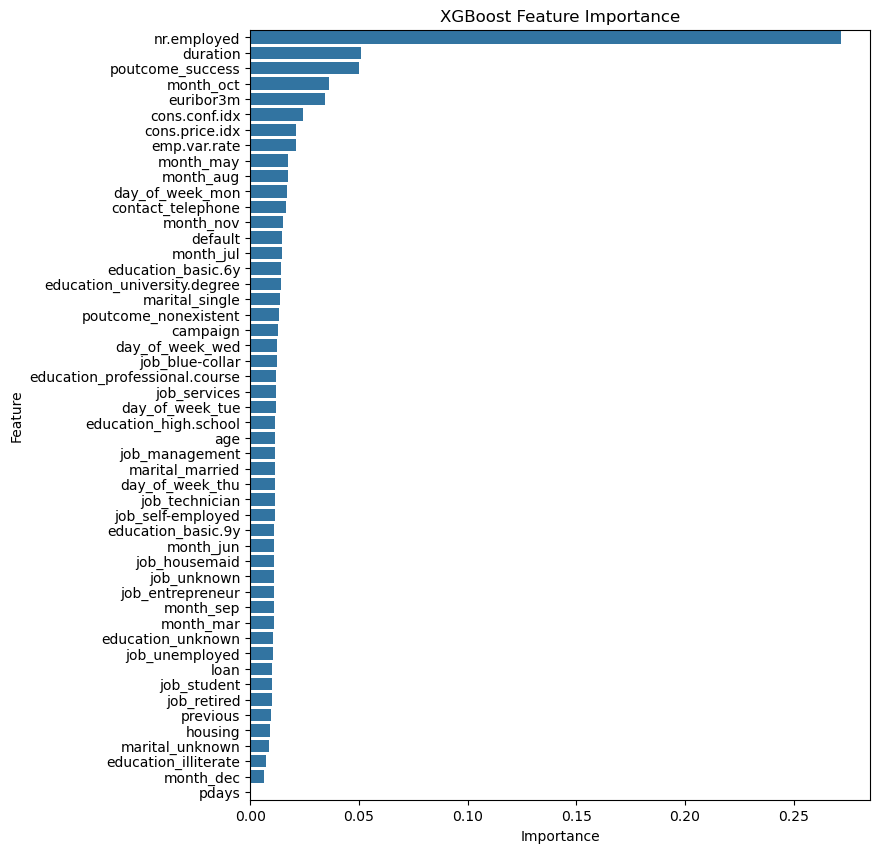

In [26]:
# Feature importance
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = xgb_model.feature_importances_
features = X_train.columns
importance_df = (
    pd.DataFrame({'Feature': features, 'Importance': feature_importance})
    .sort_values(by='Importance', ascending=False)
)

plt.figure(figsize=(8, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("XGBoost Feature Importance")
plt.show()